In [2]:
# load pandas and numpy
import pandas as pd
import numpy as np
import re
import os
import sys
import seaborn as sns

def get_tables(is_covariates, models, datasets, time_steps):
    # create dataframes for MSE and MAE with columns for each dataset and rows for each model
    df_rmse = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] + 
                        [dataset + ' OOD' for dataset in datasets], index=models)
    df_mae = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models)
    df_likelihood = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models[1:]) # no likelihood for ARIMA
    df_calibration = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models[1:]) # no calibration for ARIMA
    for model in models:
        for dataset in datasets:
            filename = f"../output/{model}_{dataset}.txt" if not is_covariates else f"../output/{model}_covariates_{dataset}.txt"

            if not os.path.isfile(filename):
                print(filename)
                continue

            with open(filename, 'r') as f:
                for line in f:
                    if line.startswith('ID median of (MSE, MAE):'):
                        id_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' ID'] = float(id_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' ID'] = float(id_mse_mae[1])
                    elif line.startswith('OOD median of (MSE, MAE):'):
                        ood_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' OOD'] = float(ood_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' OOD'] = float(ood_mse_mae[1])
                    elif line.startswith('ID likelihoods:'):
                        id_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' ID'] = float(id_likelihoods[0])
                    elif line.startswith('OOD likelihoods:'):
                        ood_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' OOD'] = float(ood_likelihoods[0])
                    elif line.startswith('ID calibration errors:'):
                        id_calib = re.findall(r'-?\d+\.\d+', line)
                        id_calib = np.mean([float(x) for x in id_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' ID'] = id_calib
                    elif line.startswith('OOD calibration errors:'):
                        ood_calib = re.findall(r'-?\d+\.\d+', line)
                        ood_calib = np.mean([float(x) for x in ood_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' OOD'] = ood_calib
    
    # sort columns for all dataframes
    df_rmse = df_rmse.reindex(sorted(df_rmse.columns), axis=1)
    df_mae = df_mae.reindex(sorted(df_mae.columns), axis=1)
    df_likelihood = df_likelihood.reindex(sorted(df_likelihood.columns), axis=1)
    df_calibration = df_calibration.reindex(sorted(df_calibration.columns), axis=1)

    return df_rmse, df_mae, df_likelihood, df_calibration

models = ['arima', 'nhits', 'tft', 'linreg', 'xgboost', 'transformer']
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
time_steps = 12

df_nocov_rmse, df_nocov_mae, _, _ = get_tables(False, models, datasets, time_steps) 

nocovmodels = [m for m in models if m != "arima"]
df_cov_rmse, df_cov_mae, _, _ = get_tables(True, models, datasets, time_steps) 

../output/arima_covariates_weinstock.txt
../output/arima_covariates_dubosson.txt
../output/arima_covariates_colas.txt
../output/arima_covariates_iglu.txt
../output/arima_covariates_hall.txt


Mean of all errors (no cov):  9.726042182631375
(5%, 95%) percentile of all errors (no cov):  (4.541400855580966, 15.42294610063235)


,colas ID,colas OOD,dubosson ID,dubosson OOD,hall ID,hall OOD,iglu ID,iglu OOD,weinstock ID,weinstock OOD
arima,5.796469,5.913457,13.531802,18.749036,8.632595,8.219086,10.530744,11.75091,13.39926,15.873514
nhits,5.933243,5.676579,17.452712,18.198311,7.682546,7.743926,13.791463,14.63776,13.289205,14.523855
tft,5.61978,5.513255,18.365973,17.49817,7.916066,8.121148,13.734609,12.428119,14.32445,15.253247
linreg,5.263553,5.330297,12.068422,15.690512,7.383182,7.860028,11.682952,11.976039,13.602916,15.575272
xgboost,6.421443,6.179795,21.17623,17.574744,7.579501,7.493295,12.79958,9.763451,13.633552,15.364077
transformer,6.474332,5.970448,16.623158,15.705411,7.888005,8.178762,15.120008,14.036778,13.223833,14.150097


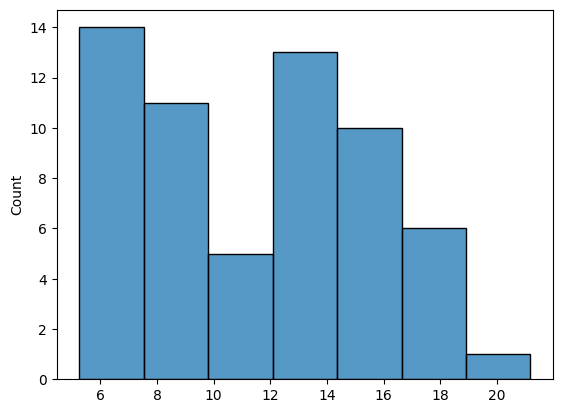

In [3]:
# 1. Range of errors

sns.histplot(df_nocov_rmse.stack()) # how to calculate 95% error bars if data isn't normal?
# sns.histplot(df_cov_rmse.stack()) # how to calculate 95% error bars if data isn't normal?

print("Mean of all errors (no cov): ", df_nocov_mae.stack().mean())
print("(5%, 95%) percentile of all errors (no cov): ", (np.percentile(df_nocov_mae.stack().to_numpy(), 5), np.percentile(df_nocov_mae.stack().to_numpy(), 95)))

# print("Mean of all errors (cov): ", df_cov_mae.stack().mean())
# print("Std of all errors (cov): ", df_cov_mae.stack().std())
df_nocov_rmse

(0.33359310327408315, -2.25779151941322, 3.1055639707044493)

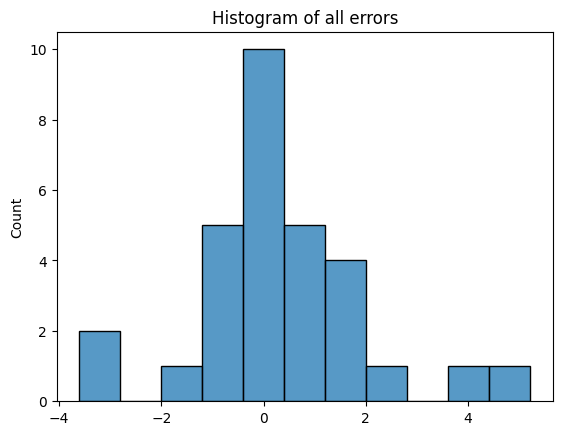

In [4]:
# 2. ID compared to OOD - axis along datasets
ood_minus_id = np.zeros(0)
for dataset in datasets:
    delta = df_nocov_rmse[f"{dataset} OOD"] - df_nocov_rmse[f"{dataset} ID"]
    ood_minus_id = np.append(delta, ood_minus_id)

sns.histplot(ood_minus_id).set_title("Histogram of all errors")
(np.mean(ood_minus_id), np.percentile(ood_minus_id, 5), np.percentile(ood_minus_id, 95))


,arima,nhits,tft,linreg,xgboost,transformer
0,0.952099,1.00799,1.025907,1.064585,0.988626,1.036861
1,1.115867,1.061364,0.904876,1.025087,0.762795,0.928358
2,1.020183,0.956741,0.981045,1.01268,0.962369,0.922172
3,1.385553,1.042721,0.952749,1.30013,0.829928,0.944791
4,1.184656,1.092906,1.06484,1.144995,1.126931,1.070045


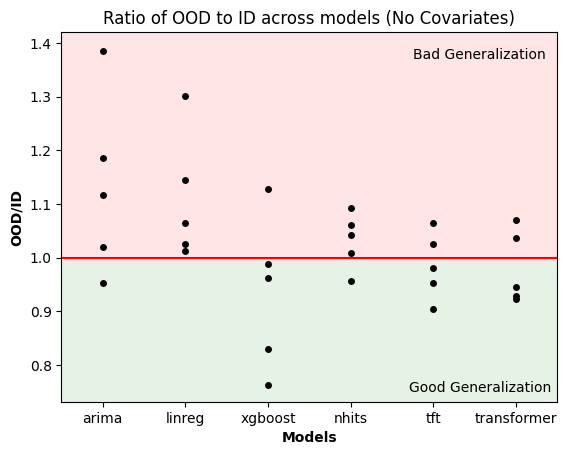

In [76]:
# 2. ID compared to OOD - axis along datasets
ratios = pd.DataFrame()
for model in models:
    ood_div_id = np.zeros(0)
    for dataset in datasets:
        delta = df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} OOD"]/df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]
        ood_div_id = np.append(delta, ood_div_id)

    ratios[model] = ood_div_id

import matplotlib.pyplot as plt

# i = 2
# j = 3
# fig, ax = plt.subplots(i,j)

# for n, (key, val) in enumerate(ratios.items()):
#     # print(n, n//j, n%j)
#     sns.histplot(ratios[key], ax=ax[n//j, n%j]).set_title(key)
#     # print(key, np.mean(val), np.percentile(val, 5), np.percentile(val, 95))

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.suptitle("OOD-ID for all models")


# sns.pointplot(ratios, x)
df = ratios.stack().reset_index()
fig = sns.stripplot(df, x=df["level_1"], y=0, order=["arima", "linreg", "xgboost", "nhits", "tft", "transformer"], jitter=False, color="black")
fig.axhline(1, color="red")
fig.set_ylabel("OOD/ID", weight=900)
fig.set_title("Ratio of OOD to ID across models (No Covariates)")
fig.set_xlabel("Models", weight=900)
fig.set_ylim(bottom=None, top=1.42)
fig.axhspan(1, 1.5, facecolor="red", alpha=0.1)
fig.axhspan(0, 1, facecolor="green", alpha=0.1)
fig.text(3.75, 1.37, "Bad Generalization")
fig.text(3.70, 0.75, "Good Generalization")

ratios


,model,dataset,error,type
0,arima,colas,5.796469,ID
2,arima,dubosson,13.531802,ID
4,arima,hall,8.632595,ID
6,arima,iglu,10.530744,ID
8,arima,weinstock,13.39926,ID
10,nhits,colas,5.933243,ID
12,nhits,dubosson,17.452712,ID
14,nhits,hall,7.682546,ID
16,nhits,iglu,13.791463,ID
18,nhits,weinstock,13.289205,ID


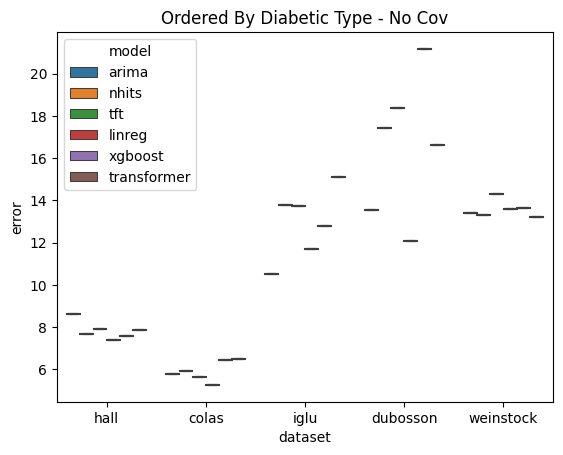

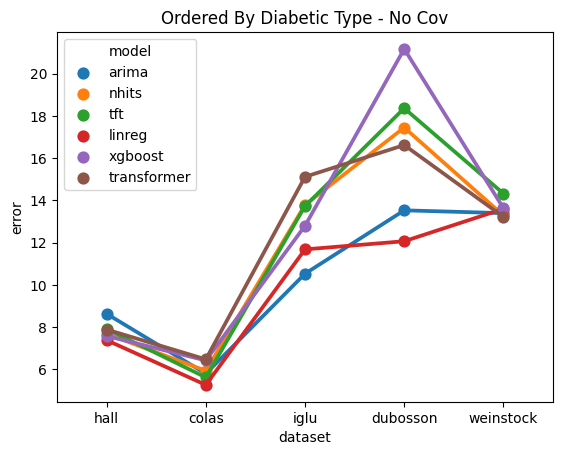

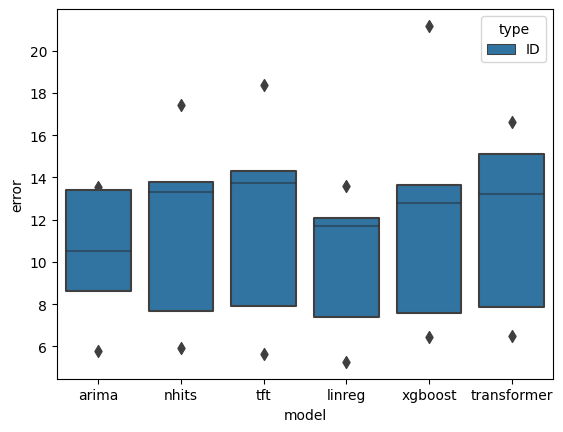

In [14]:
# 3. LOTS OF PLOTS

# prepare the data
def prepare_data(df):
    df = df.stack().reset_index()
    df["type"] = df["level_1"].apply(lambda x: "ID" if "ID" in x else "OOD")
    df = df[df["type"] == "ID"]
    df.columns = ["model", "dataset", "error", "type"]
    df["dataset"] = df["dataset"].apply(lambda x: x.split(" ")[0])
    return df

df1 = prepare_data(df_nocov_rmse)

# 3a.Ordered by difficulty
plt.figure()
sns.boxplot(df1, x=df1["dataset"], y="error", hue=df1["model"], order=["hall","colas","iglu","dubosson","weinstock"]).set_title("Ordered By Diabetic Type - No Cov")

plt.figure()
sns.pointplot(df1, x=df1["dataset"], y="error", hue=df1["model"], order=["hall","colas","iglu","dubosson","weinstock"]).set_title("Ordered By Diabetic Type - No Cov")

#  ID vs. OOD
plt.figure()
sns.boxenplot(df1, x="model", y="error", hue="type")

df1


